# CS 440 Final Project: Clickbait Detection

### Team members: Joshua Burris, Caleb Tong

# Introduction

The number of clickbait advertisement on the internet that has risen dramatically for the past few years is becoming a problem. Thus, we decided to conduct an experiment on clickbait detection based using a Language model (instead of a more commonly used Naive Bayes model). 

The reason for this methodology includes that we are more familiar with using the language model, but also we are curious about the results. Normally speaking, the Naive Bayes model is used for categorising / classification of a sentence or an input. Language models on the other hand are used for prediction for the next best word to continue the sentence. But the question remain, since language model is more powerful, can it do what Naive Bayes do, just as well?

The code below is the experiment we decided to conduct.

### Definition of Clickbait

As we proceed to con duct the experiment, do take note that our classification of what is and what is not clickbait, is based on how interesting it sounds. As such it does not only include titles that are false news or titles of advertisements that doesn't exist but are just there to redirect the user to another website (not what was advertised), etc, but it also includes that which are real news, but really intrigues the user. 

Formally, we define clickbait as:

<b> Content on the internet whose main purpose is to attract attention and encourage visitors to click on a link to a particular web page. </b>


In [1]:
# Testing
testing_mode = False
argv = ['train/train_clickbait.txt', 'test/test_clickbait.txt', 'train/train_nonclickbait.txt', 'test/test_nonclickbait.txt']

### Language Model

First of all, we created the language model class that is similar to what we did in our class assignment in CS440. This class allows us to train a model given a dataset of clickbait titles, a dataset of nonclickbait titles, and test the model on another (exclusive) dataset of clickbait titles and that of nonclickbait titles.

In [2]:
import math, string
from collections import Counter

class language_model:
    
    def __init__(self, ngram=1) :
        self.ngram = ngram
    
    def train(self, text) :
        
        # Get sentences
        sentences = self.get_sentences(text)
        
        # Get unigram frequency data
        self.unigrams = Counter()
        for s in sentences :
            for w in s.split() :
                self.unigrams[w] += 1
        
        if testing_mode :
            print('Unigrams:')
            for word, freq in self.unigrams.most_common(10) :
                print("{}\t{}".format(word, freq))
            print()
            
        # Get the number of total unigrams, and the total sum of their frequencies
        self.V = len(self.unigrams)
        self.total_count = sum(self.unigrams.values())
        
        # If we are using an ngram of 2 or more we need a frequency list of bigrams
        if self.ngram > 1:
            self.bigrams = Counter()
            
            for s in sentences :
                words = s.split()
                for i in range(len(words) - 1):
                    self.bigrams[words[i] +' '+ words[i+1]] += 1
                        
            # Update V and total_count if we are using more than one gram
            self.V = len(self.bigrams)
            self.total_count = sum(self.bigrams.values())
            
            if testing_mode :
                print('Bigrams:')
                for word, freq in self.bigrams.most_common(10) :
                    print("{}\t\t{}".format(word, freq))
                print()
        
        # If we are using an ngram of 3 or more we need a frequency list of trigrams
        if self.ngram > 2:
            self.trigrams = Counter()
            
            for s in sentences :
                words = s.split()
                for i in range(len(words) - 2):
                    self.trigrams[words[i] +' '+ words[i+1] +' '+ words[i+2]] += 1
            
            # Update V and total_count if we are using more than one gram
            self.V = len(self.trigrams)
            self.total_count = sum(self.trigrams.values())
            
            if testing_mode :
                print('Trigrams:')
                for word, freq in self.trigrams.most_common(10) :
                    print("{}\t\t\t{}".format(word, freq))
                print()
        
        if testing_mode :
            print('Number of ngrams:', self.V)
            print('Total of ngram frequencies:', self.total_count)
            print()
    
    def test(self, text) :
        
        # Get sentences
        sentences = self.get_sentences(text)
        
        # Calculate sparsity
        non_entries = 0
        entries = 0
        for s in sentences :
            words = s.split()
            for i in range(len(words) - (self.ngram - 1)) :
                gram = ' '.join(words[i:i+self.ngram])
                if self.count([gram]) :
                    non_entries += 1
                entries += 1
        
        self.sparsity = non_entries / entries
        
        return self.perplexity(sentences)
    
    def perplexity(self, sentences):
        return math.pow(2, self.entropy(sentences))
    
    def entropy(self, sentences):
        e = 0
        offset = self.ngram - 1
        length = 0
        
        for s in sentences :
            words = s.split()
            length += len(words)
            for i in range(offset, len(words)) :
                # context is the previous word/words for the bigram/trigram.
                context = words[i - offset : i]
                e += -math.log(self.probability(words[i], context), 2)  
        return e / length
    
    def probability(self, word, context):
        return (self.count(context + [word]) + 1) / (self.count(context) + self.V)
    
    def count(self, context):
        size = len(context)
        words = ' '.join(context)
        
        if size == 1: return self.unigrams.setdefault(words, 0)
        if size == 2: return self.bigrams.setdefault(words, 0)
        if size == 3: return self.trigrams.setdefault(words, 0)
        
        return 0
    
    def get_sentences(self, text):
        
        sentences = []
        
        lines = text.split('\n')
        
        for l in lines :
            # Convert to lower case.
            l = l.lower()
            
            # Convert question marks (?), colons (:) and exclamation marks (!) to periods.
            # Dashes should be converted to spaces.
            # Remove all punctuation marks other than the period (commas, semicolons, underscores and quotes).
            l = l.translate(str.maketrans('?:!-', '... ', string.punctuation.replace('.', '')))
            
            # Replace whitespace with a single space.
            l = ' '.join(l.split())
            
            new_line = ''
            for i in range(len(l)) :
                if l[i] == '.' and i != len(l) - 1 and l[i+1] != ' ' :
                    continue
                else :
                    new_line += l[i]
            l = new_line
            
            # Parse the line into sentences, adding beginning-of-sentence and end-of-sentence tokens.
            for s in l.split('.') :
                s = s.strip()
                if s :
                    sentences.append('<s> '+ s +' </s>')
        
        return sentences

### Which N-gram is the most useful

Following that, we ran the program through 3 different ngram models. This is to find the best ngram model by seeing which model provides a better cut off point for perplexity value, as that is what we will use to determine whether a title is clickbait or not.

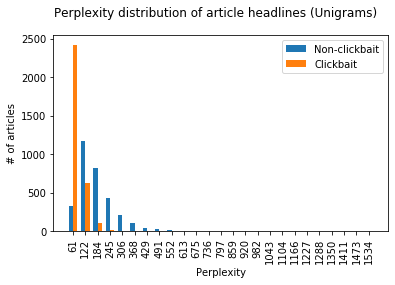

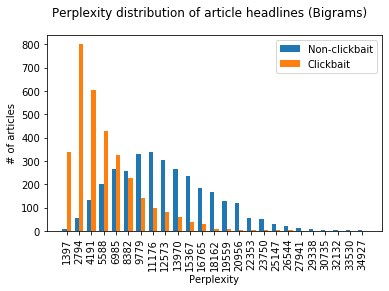

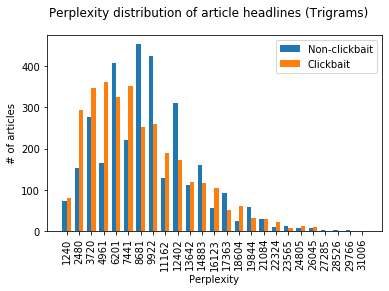

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def get_bins(num_bins, maximum, data) :
    bins = [0]*num_bins
    for p in data :
        if p < maximum :
            bins[int((p / maximum) * num_bins)] += 1
    return bins

# Graph shaping values:
num_bins = 25
width = 0.35

for ngram in range(1, 4) :
    nc_perps = []
    c_perps = []
    maximum = 0
    
    c_model = language_model(ngram)
    c_model.train(open(argv[0], 'r').read())
    for line in open(argv[1], 'r').readlines() :
        line = line.strip()
        if line :
            perp = c_model.test(line)
            c_perps.append(perp)
            if perp > maximum :
                maximum = perp

    nc_model = language_model(ngram)
    nc_model.train(open(argv[2], 'r').read())
    for line in open(argv[3], 'r').readlines() :
        line = line.strip()
        if line :
            perp = nc_model.test(line)
            nc_perps.append(perp)
            if perp > maximum :
                maximum = perp
        
    nc_bins = get_bins(num_bins, maximum, nc_perps)
    c_bins = get_bins(num_bins, maximum, c_perps)

    ind = np.arange(num_bins)

    plt.bar(ind, nc_bins, width, label='Non-clickbait')
    plt.bar(ind+width, c_bins, width, label='Clickbait')

    plt.xlabel('Perplexity')
    plt.ylabel('# of articles')
    title = 'Perplexity distribution of article headlines'
    if ngram == 1 : plt.suptitle(title + ' (Unigrams)')
    elif ngram == 2 : plt.suptitle(title + ' (Bigrams)')
    elif ngram == 3 : plt.suptitle(title + ' (Trigrams)')
    plt.legend(loc='best')

    # You need to change xticks or else they will display 0 to num_bins
    plt.xticks(ind + width / 2, (int(((i+1) / num_bins) * maximum) for i in range(num_bins)), rotation='vertical')
    plt.subplots_adjust(bottom=0.2)
    
    plt.show()

As seen above, it seems that the perplexity distribution graph for Bigrams looks the best (more bell-shaped curve). It can be noted that the Bigram really shows a cut off point for perplexity of what is and is not clickbait. But is using the Bigram model the most accurate?

## Calculating if it's clickbait

In [4]:
best_ngram = 1

clickbait_model = language_model(best_ngram)
clickbait_model.train(open(argv[0], 'r').read())

notclickbait_model = language_model(best_ngram)
notclickbait_model.train(open(argv[2], 'r').read())

def is_clickbait(article_headline) :
    clickbait_perp = clickbait_model.test(article_headline)
    notclickbait_perp = notclickbait_model.test(article_headline)
    
    if clickbait_perp < notclickbait_perp :
        return True, 100*( 1-(clickbait_perp/(clickbait_perp+notclickbait_perp)) )
    else :
        return False, 100*( 1-(notclickbait_perp/(clickbait_perp+notclickbait_perp)) )

In [5]:
best_ngram = 1

clickbait_model = language_model(best_ngram)
clickbait_model.train(open(argv[0], 'r').read())

notclickbait_model = language_model(best_ngram)
notclickbait_model.train(open(argv[2], 'r').read())

def is_clickbait(article_headline) :
    clickbait_perp = clickbait_model.test(article_headline)
    notclickbait_perp = notclickbait_model.test(article_headline)
    
    if clickbait_perp < notclickbait_perp :
        return True, 100*( 1-(clickbait_perp/(clickbait_perp+notclickbait_perp)) )
    else :
        return False, 100*( 1-(notclickbait_perp/(clickbait_perp+notclickbait_perp)) )

In [6]:
for ngram in range(1, 4) :
    print('ngram:', ngram)
    
    c_model = language_model(ngram)
    c_model.train(open(argv[0], 'r').read())
    
    nc_model = language_model(ngram)
    nc_model.train(open(argv[2], 'r').read())
    
    correct = 0.0
    total = 0.0
    for line in open(argv[1], 'r').readlines() :
        line = line.strip()
        if line :
            c_perp = c_model.test(line)
            nc_perp = nc_model.test(line)
            if c_perp < nc_perp :
                correct += 1.0
            total += 1.0
    
    c_accuracy = correct / total
    print('Clickbait accuracy: {:.2f}%'.format(100.0*c_accuracy))
    
    correct = 0.0
    total = 0.0
    for line in open(argv[3], 'r').readlines() :
        line = line.strip()
        if line :
            c_perp = c_model.test(line)
            nc_perp = nc_model.test(line)
            if nc_perp < c_perp :
                correct += 1.0
            total += 1.0
    
    nc_accuracy = correct / total
    print('Nonclickbait accuracy: {:.2f}%'.format(100.0*nc_accuracy))
    print()

ngram: 1
Clickbait accuracy: 99.84%
Nonclickbait accuracy: 82.89%

ngram: 2
Clickbait accuracy: 99.75%
Nonclickbait accuracy: 80.75%

ngram: 3
Clickbait accuracy: 99.16%
Nonclickbait accuracy: 53.03%



As shown, it is clear that the Unigram is slightly more accurate with the accuracy of both clickbait and non-clickbait titles. 

### But....
But don't just trust our results baselessly. Below is a code section that allows you to input a title and our code will determine whether it sounds like clikbait or not.

## Try it yourself

In [7]:
print("Press \"stop\", \"quit\", or \"exit\" to stop", end='\n\n')

while True :
    article_headline = input('Give me an article headline: ').lower()
    
    if article_headline == 'stop' or article_headline == 'exit' or article_headline == 'quit' :
        break
    
    is_cb, percentage = is_clickbait(article_headline)
    
    if is_cb :
        print("We are {:.2f}% sure it's clickbait".format(percentage))
    else :
        print("We are {:.2f}% sure it's not clickbait".format(percentage))
    
    print()

Press "stop", "quit", or "exit" to stop

Give me an article headline: The Tax Break for Children, Except the Ones Who Need It Most
We are 72.93% sure it's clickbait

Give me an article headline: As Protests Rage, Is India Moving Closer to Becoming a Hindu Nation?
We are 53.56% sure it's not clickbait

Give me an article headline: Purdue Pharma’s Payments to Sacklers Soared Amid Opioid Crisis
We are 61.27% sure it's not clickbait

Give me an article headline: How Mariah Carey’s ‘All I Want for Christmas Is You’ Finally Hit No. 1
We are 75.25% sure it's clickbait

Give me an article headline: Feral Pigs Roam the South. Now Even Northern States Aren’t Safe.
We are 51.01% sure it's not clickbait

Give me an article headline: stop


# Conclusion



First of all, it <b>is</b> possible to use a language model to classify/categorize something. I believe that the biggest problem using this methodology is finding the significant cutoff point of perplexity value for the category. Then again, this is under the consideration that we have already done the initial code/work before, thus making it easier. What is surprising, is though the Bigram model is considered the best model to work with based on a dataset of training, it appears that the Unigram model would be more accurate in determining the result.